# ConVNext

In [ ]:
# 🔹 System & File Utils
import os
import random

# 🔹 Data Handling
import numpy as np
import pandas as pd

# 🔹 Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 🔹 Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 TensorFlow Core
import tensorflow as tf

# 🔹 Keras Applications & Layers
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.applications.convnext import preprocess_input
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# 🔹 Training Utils
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# 🔹 MLflow tracking
from utils.MLFlowTrackingConfig import MLFlowTracking

In [6]:
# load the dataset

data = np.load('../artifacts/data_ingestion/Preprocessed Dataset/train_data.npz')

# X
X = data['arr_0']

# y
y = data['arr_1']

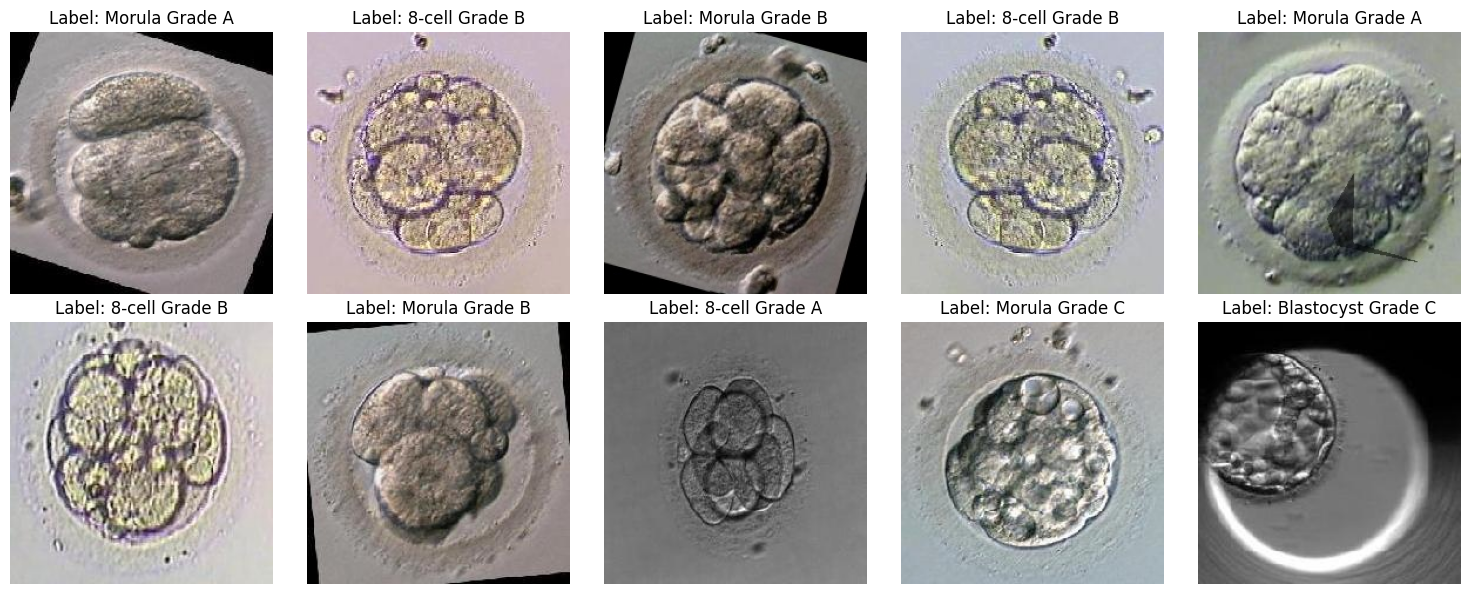

In [10]:
# show the random 10 images

plt.figure(figsize=(15, 6))
for i, idx in enumerate(random.sample(range(len(X)), 10)):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[idx].astype('uint8'))
    plt.title(f"Label: {y[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
# shape

X.shape

(8621, 224, 224, 3)

In [12]:
# labels counts

pd.Series(y).value_counts()

,count
Morula Grade C,900
Morula Grade B,900
Morula Grade A,900
Error Images,899
Blastocyst Grade C,893
Blastocyst Grade B,881
Blastocyst Grade A,876
8-cell Grade A,802
8-cell Grade C,796
8-cell Grade B,774


In [13]:
# Normalize the dataset

X = preprocess_input(X)


In [14]:
# Handel the labels

from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
y_encoded = label_encoder.fit_transform(y)

# matrix
labels = to_categorical(y_encoded, len(label_encoder.classes_))

In [15]:
# show the first five labels

labels[:5]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, labels, test_size= 0.1, random_state=42, stratify = labels)

In [17]:
# check the shape -> train

x_train.shape, y_train.shape

((7758, 224, 224, 3), (7758, 10))

In [18]:
# check the shape -> test

x_test.shape, y_test.shape

((863, 224, 224, 3), (863, 10))

In [19]:
# Model

# image shape
input_shape = (224, 224, 3)

# base model and add top layer imagenet weights
base_model = ConvNeXtBase(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze
base_model.trainable = False

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


In [20]:
# Custom Head
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(labels.shape[1], activation='softmax')(x)
model = Model(inputs, outputs)

In [21]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,835,530 (335.07 MB)

 Trainable params: 267,018 (1.02 MB)

 Non-trainable params: 87,568,512 (334.05 MB)

In [22]:
# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

In [24]:
# run the model

history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    validation_data=(x_test, y_test),
    epochs=100,
    callbacks=[early_stop, reduce_lr],
)

Epoch 1/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 136s 441ms/step - accuracy: 0.5036 - loss: 1.4351 - val_accuracy: 0.7845 - val_loss: 0.6084 - learning_rate: 0.0010
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 119s 395ms/step - accuracy: 0.7444 - loss: 0.6731 - val_accuracy: 0.8447 - val_loss: 0.4105 - learning_rate: 0.0010
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 142s 394ms/step - accuracy: 0.7867 - loss: 0.5388 - val_accuracy: 0.8528 - val_loss: 0.3618 - learning_rate: 0.0010
Epoch 4/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 142s 394ms/step - accuracy: 0.8266 - loss: 0.4537 - val_accuracy: 0.8957 - val_loss: 0.2860 - learning_rate: 0.0010
Epoch 5/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 95s 392ms/step - accuracy: 0.8493 - loss: 0.3848 - val_accuracy: 0.8992 - val_loss: 0.2727 - learning_rate: 0.0010
Epoch 6/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 142s 394ms/step - accuracy: 0.8588 - loss: 0.3564 - val_accuracy: 0.9189 - val_loss: 0.2335 - learning_rate: 0.0010
Epoch 7/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 95s 390ms/step - a

In [25]:
# save the model 

model.save("ConvNeXtBase.h5")

**Train and Validation Loss Plot**

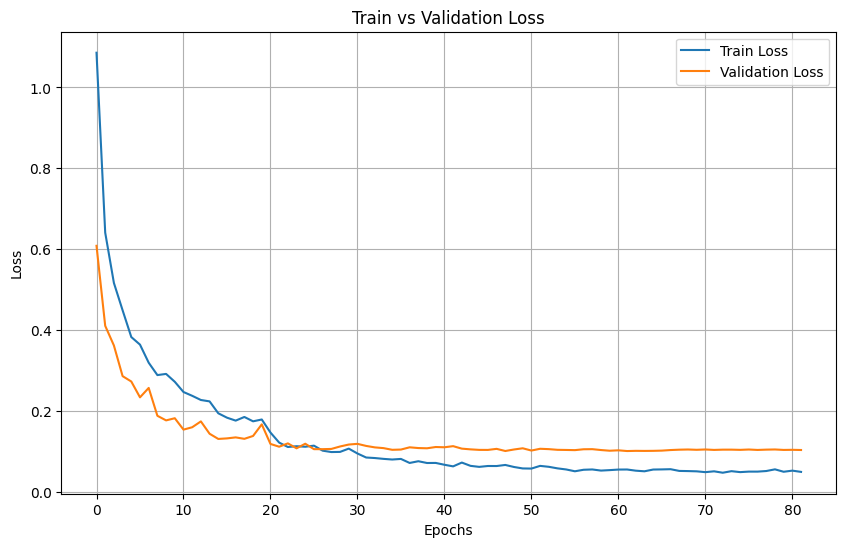

In [26]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Train and Validation Accuracy Plot**

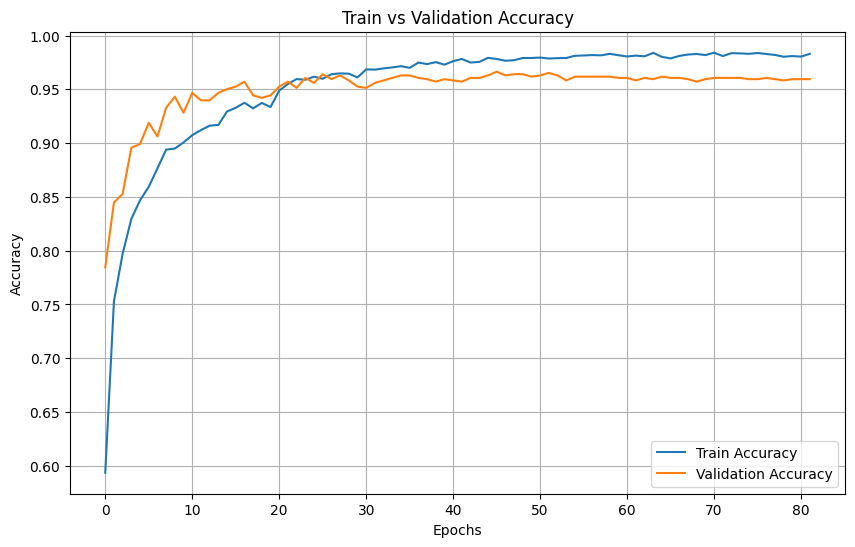

In [27]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Model Evaluation

### Test data

In [28]:
test_data = np.load('/content/test_data.npz')

X_test = test_data['arr_0']

y_test = test_data['arr_1']

In [29]:
labelEncodeY = LabelEncoder()

y_test = labelEncodeY.fit_transform(y_test)

y_test = to_categorical(y_test, len(labelEncodeY.classes_))

y_test = np.array(y_test)

In [30]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1, batch_size = 16)

print(f"🧪 Test Accuracy: {test_accuracy * 100:.2f}%")

print(f"📉 Test Loss: {test_loss:.4f}")

60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 233ms/step - accuracy: 0.9435 - loss: 0.1415
🧪 Test Accuracy: 95.09%
📉 Test Loss: 0.1157


### Train data

In [31]:
train_data = np.load('/content/train_data.npz')

X_train = train_data['arr_0']

y_train = train_data['arr_1']

In [32]:
labelEncodeY = LabelEncoder()

y_train = labelEncodeY.fit_transform(y_train)

y_train = to_categorical(y_train, len(labelEncodeY.classes_))

y_train = np.array(y_train)

In [33]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=1, batch_size = 8)

print(f"🧪 Train Accuracy: {train_accuracy * 100:.2f}%")

print(f"📉 Train Loss: {train_loss:.4f}")

1078/1078 ━━━━━━━━━━━━━━━━━━━━ 107s 94ms/step - accuracy: 0.9943 - loss: 0.0182
🧪 Train Accuracy: 99.37%
📉 Train Loss: 0.0194


### 🏷️ Update MLflow Tracking Configuration for Remote 

In [9]:
MLFlowTracking(model, 224, 3, 32, False, 100, 10, 'imagenet', 1.9531e-06, 0.1032, 0.9943, 0.9435, 'ConvNeXtBase')

Accessing as revanth-kumar-01-ai
Initialized MLflow to track repo 
"revanth-kumar-01-ai/360DigitMG-Training-Phase"
Repository revanth-kumar-01-ai/360DigitMG-Training-Phase initialized!


2025/04/22 18:44:12 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/04/22 18:44:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'ConvNeXtBase'.
2025/04/22 18:46:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ConvNeXtBase, version 1
Created version '1' of model 'ConvNeXtBase'.


🏃 View run powerful-dove-879 at: https://dagshub.com/revanth-kumar-01-ai/360DigitMG-Training-Phase.mlflow/#/experiments/0/runs/43d31b3a76514612a984799c35531813
🧪 View experiment at: https://dagshub.com/revanth-kumar-01-ai/360DigitMG-Training-Phase.mlflow/#/experiments/0
✅ MLflow tracking logged successfully! 🚀
